# Analysis of Finished Cases

## Set up a dashboard to monitor ongoing dask operations.

In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import pandas as pd

client = Client()
client

/home/advin4603/PrecogRecruitmentTask/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43409 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43409/status,
Dashboard: http://127.0.0.1:43409/status,Workers: 4
Total threads: 8,Total memory: 15.52 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43539,Workers: 4
Dashboard: http://127.0.0.1:43409/status,Total threads: 8
Started: Just now,Total memory: 15.52 GiB
Comm: tcp://127.0.0.1:44249,Total threads: 2
Dashboard: http://127.0.0.1:36019/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:40863,


## Load case data from parquet files

Dask uses lazy loading so data isn't loaded onto the RAM.

In [2]:
date_parser = lambda x: pd.to_datetime(str(x), errors='coerce', format="%d-%m-%Y")
case_date_parser = lambda x: pd.to_datetime(str(x), errors='coerce', format="%Y-%m-%d")

cases_dtype = {
    "ddl_case_id": "string[pyarrow]",
    "year": "int16",
    "state_code": "category",
    "dist_code": "category",
    "court_no": "category",
    "cino": "string[pyarrow]",
    'judge_position': "string[pyarrow]",
    "female_defendant": "category",
    "female_adv_def": "category",
    "female_adv_pet": "category",
    "type_name": "Int16",
    "purpose_name": "Int16",
    "disp_name": "Int16",
    "date_of_filing": "string[pyarrow]",
    "date_of_decision": "string[pyarrow]",
    "date_first_list": "string[pyarrow]",
    "date_last_list": "string[pyarrow]",
    "date_next_list": "string[pyarrow]",
    "act": "Int16",
    "section": "Int64",
    "bailable_ipc": "category",
    "number_sections_ipc": "Int16",
    "criminal": "category"
}

cases = dd.concat([dd.read_parquet(f"./Parquet/cases_acts/{year}/", dtype=cases_dtype,
                                   columns=["date_of_decision", "date_of_filing", "year", "type_name", "disp_name", "act", "section"],
                                   parse_dates=["date_of_filing", "date_of_decision"]) for year in range(2010, 2019)])
cases

,date_of_decision,date_of_filing,year,type_name,disp_name,act,section
npartitions=660,,,,,,,
,datetime64[ns],datetime64[ns],int16,Int16,Int16,Int16,float64
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


## Filter all the Cases and perform sanity checks to ensure proper data

In [3]:
finished_cases = cases.dropna(subset=["date_of_filing", "date_of_decision", "disp_name"])
finished_cases = finished_cases[
    ((finished_cases["date_of_decision"] - finished_cases["date_of_filing"]).dt.total_seconds() >= 0) &
    ((pd.to_datetime('today') - finished_cases["date_of_decision"]).dt.total_seconds() >= 0) &
    (finished_cases["date_of_filing"].dt.year == finished_cases["year"])
    ]

## Calculate duration in days

In [4]:
finished_cases["duration"] = (finished_cases["date_of_decision"] - finished_cases["date_of_filing"]).dt.days
finished_cases.head()

,date_of_decision,date_of_filing,year,type_name,disp_name,act,section,duration
ddl_case_id,,,,,,,,
01-01-01-200308002162010,2011-06-19,2010-12-13,2010,790,42,4759,132871.0,188
01-01-01-201908000012010,2010-01-11,2010-01-02,2010,1429,25,4759,1123673.0,9
01-01-01-201908000022010,2013-12-11,2010-01-02,2010,1429,22,4759,132871.0,1439
01-01-01-201908000032010,2010-02-11,2010-01-02,2010,1429,25,4759,1123673.0,40
01-01-01-201908000042010,2010-02-12,2010-01-02,2010,1429,25,4759,1123673.0,41


## Load the type name key

In [5]:
type_name_key = dd.read_csv("./csv/keys/keys/type_name_key.csv",
                            dtype={"year": "int16", "type_name": "Int16", "type_name_s": "string[pyarrow]",
                                   "count": "int64"})
type_name_key.head()

,year,type_name,type_name_s,count
0,2010,1,(m) t.s.,18
1,2010,2,(sc),2
2,2010,3,..mact 166,97
3,2010,4,04 complaint cases,19
4,2010,5,04 criminal case,21


## Load the disp name key

In [6]:
disp_name_key = dd.read_csv("./csv/keys/keys/disp_name_key.csv",
                            dtype={"year": "int16", "disp_name": "Int16", "disp_name_s": "string[pyarrow]",
                                   "count": "int64"})
disp_name_key.head()

,year,disp_name,disp_name_s,count
0,2010,1,258 crpc,15765
1,2010,2,abated,22021
2,2010,3,absconded,16773
3,2010,4,acquitted,406015
4,2010,5,allowed,244023


## Merge keys with Finished Cases

In [7]:
finished_cases = dd.merge(finished_cases, disp_name_key[["year", "disp_name", "disp_name_s"]], how="left",
                          on=["year", "disp_name"])
finished_cases = dd.merge(finished_cases, type_name_key[["year", "type_name", "type_name_s"]], how="left",
                          on=["year", "type_name"])
finished_cases.head()

,date_of_decision,date_of_filing,year,type_name,disp_name,act,section,duration,disp_name_s,type_name_s
0,2011-06-19,2010-12-13,2010,790,42,4759,132871.0,188,referred to lok adalat,civil m.a.
1,2010-01-11,2010-01-02,2010,1429,25,4759,1123673.0,9,disposed-otherwise,cri.m.a.
2,2013-12-11,2010-01-02,2010,1429,22,4759,132871.0,1439,dismissed,cri.m.a.
3,2010-02-11,2010-01-02,2010,1429,25,4759,1123673.0,40,disposed-otherwise,cri.m.a.
4,2010-02-12,2010-01-02,2010,1429,25,4759,1123673.0,41,disposed-otherwise,cri.m.a.


## Get Average Durations for different types of cases.

### We see that cases marked `excise act gr hilsa` take the longest on average to complete.

### We also note that cases marked `escc` vary the most in their durations.

In [9]:
type_avg_durations = finished_cases[["type_name_s", "duration"]].groupby("type_name_s").agg(["mean", "std"])
type_avg_durations.compute()

duration            
                                           mean         std
type_name_s                                                
civil m.a.                           324.259959  425.336508
cri.m.a.                             271.622704  424.748195
r.c.s.                               623.948771  699.420494
munci. appeal                        787.182035  593.182894
spl.c.s.                             742.680478  626.275322
...                                         ...         ...
cri. rev. app.                        38.000000    7.071068
cr. rev..                            637.000000         NaN
suit for declaration and partition   395.000000         NaN
suit for declaration and possession  395.000000         NaN
misc.civil application               257.000000         NaN

[10073 rows x 2 columns]

## Plot the distribution of durations
Uncomment the line to make a graph for various types of cases.

### We observe that durations follow Zipf's Law where the durations are ranked in ascending order
According to zipf's law, the rank of an element is inversely related to its frequency.

What this means is that the duration of a case is distributed such that cases tend to be disposed of as soon as possible and there is no minimum amount of time that every case runs for.

<AxesSubplot: >

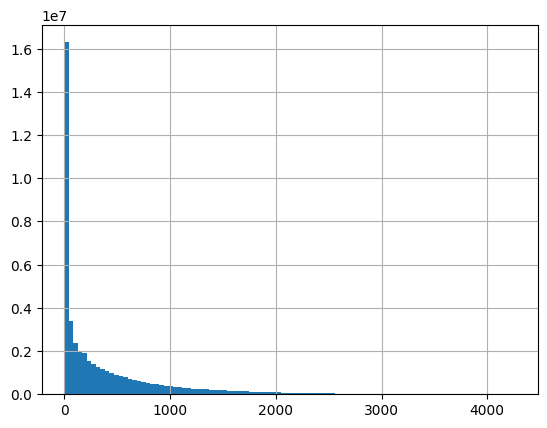

In [10]:
type_name = "cc"
type_durations = finished_cases[["type_name_s", "duration"]]
# type_durations = type_durations[type_durations["type_name_s"] == type_name]
type_durations.compute()["duration"].hist(bins=100)